In [1]:
import torch
import numpy as np
import os
import os.path as osp
import tqdm
import matplotlib.pylab as plt
from torch import nn
from torch import optim
from collections import defaultdict

## Imports based on our ready-to-use code (after you pip-install the cs233_gtda_hw4 package)
from cs233_gtda_hw4.in_out.utils import make_data_loaders
from cs233_gtda_hw4.in_out.utils import save_state_dicts, load_state_dicts
from cs233_gtda_hw4.in_out import pointcloud_dataset
from cs233_gtda_hw4.in_out.plotting import plot_3d_point_cloud


## Imports you might use if you follow are scaffold code (it is OK to use your own stucture of the models)
from cs233_gtda_hw4.models import PartAwareAutoencoder
from cs233_gtda_hw4.models.point_net import PointNet
from cs233_gtda_hw4.models.mlp import MLP

%load_ext autoreload
%autoreload 2

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


In [2]:
##
## Fixed Settings (we do not expect you to change these)
## 

n_points = 1024  # number of points of each point-cloud
n_parts = 4      # max number of parts of each shape
n_train_epochs = 400

# Students: feel free to change below -ONLY- for the bonus Question:
# I.e., use THESE hyper-parameters when you train for the non-bonus questions.

part_lambda = 0.005  # for the part-aware AE you will be using (summing) two losses:
                     # chamfer + cross-entropy
                     # do it like this: chamfer + (part_lambda * cross-entropy), 
                     # i.e. we are scaling down the cross-entropy term
init_lr = 0.009  # initial learning-rate, tested by us with ADAM optimizer (see below)

In [3]:
## Students: feel free to change below:

# batch-size of data loaders
batch_size = 128 # if you can keep this too as is keep it, 
                 # but if it is too big for your GPU, feel free to change it.

# which device to use: cpu or cuda?
# device = 'cpu'     # Note: only the "alternative" (slower) chamfer_loss in losses/nn_distance can run in cpu.
device = 'cuda'

top_in_dir = 'cs233_gtda_hw4/data/'
top_out_dir = 'cs233_gtda_hw4/data/out/'
if not osp.exists(top_out_dir):
    os.makedirs(top_out_dir)

In [4]:
# PREPARE DATA:

loaders = make_data_loaders(top_in_dir, batch_size)

for split, loader in loaders.items():
    print('N-examples', split, len(loader.dataset))
    
# BUILD MODELS:
### TODO: Student on your own:
class PartClassifier(nn.Module):
    def __init__(self, in_dim, n_parts):
        super(PartClassifier, self).__init__()
        self.hidden = nn.Conv1d(in_dim, 64, 1) # global features with points
        self.output = nn.Conv1d(64, n_parts, 1)

    def forward(self, pointclouds, global_features):
        global_features = global_features.unsqueeze(1).repeat(1, 
                                                              pointclouds.shape[1], 1)
        pointclouds = torch.cat([pointclouds, global_features], dim=2).transpose(1, 2)
        pcd_feature = self.hidden(pointclouds).relu()
        output = self.output(pcd_feature).transpose(1, 2) # (B, N, n_parts)
        return output
        
encoder = PointNet()
decoder = MLP(128,3 * n_points)
part_classifier = PartClassifier(in_dim=128+3, n_parts=n_parts)

N-examples train 750
N-examples test 150
N-examples val 50


In [5]:
part_aware_model = True # or True

# Cross entropy loss inside encoder
model = PartAwareAutoencoder(encoder, decoder, part_classifier).to(device) # Students Work here
model_tag = 'part_pc_ae'

In [6]:
optimizer = optim.Adam(model.parameters(), lr=init_lr)  # Students uncomment once you have defined your model

100%|██████████| 400/400 [00:30<00:00, 13.07it/s]


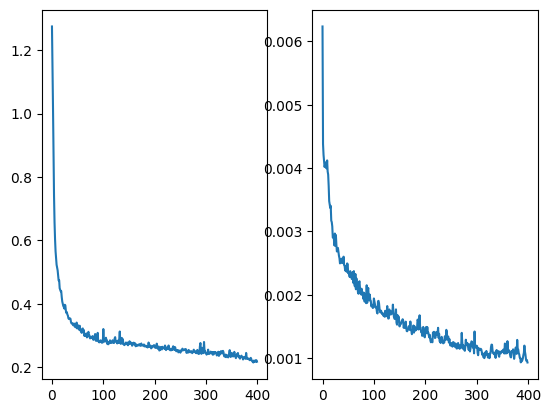

In [7]:
## Train for multiple epochs your model.
# Students: the below for-loops are optional, feel free to structure your training 
# differently.

min_val_loss = np.Inf
out_file = osp.join(top_out_dir, model_tag + 'best_model.pth')
start_epoch = 1
seg_losses = []
recon_losses = []
for epoch in tqdm.tqdm(range(start_epoch, start_epoch + n_train_epochs)):
    for phase in ['train', 'val', 'test']:
        # Students Work Here.
        epoch_recon_losses, epoch_seg_losses = model.train_with_part_one_epoch(loaders[phase], optimizer, num_classes=n_parts)
        if phase == 'val':
            seg_losses.append(epoch_seg_losses)
            recon_losses.append(epoch_recon_losses)
        epoch_losses = epoch_recon_losses + epoch_seg_losses
        # Save model if validation loss improved.
        if phase == 'val' and epoch_losses < min_val_loss:
            min_val_loss = epoch_losses
            save_state_dicts(out_file, epoch=epoch, model=model)
plt.subplot(1,2,1)
plt.plot(seg_losses, label='seg')
plt.subplot(1,2,2)
plt.plot(recon_losses, label='recon')

In [8]:
# Load model with best per-validation loss (uncomment when ready)
best_epoch = load_state_dicts(out_file, model=model)
print('per-validation optimal epoch', best_epoch)

per-validation optimal epoch 393


Part classification accuracy: 0.91205078125


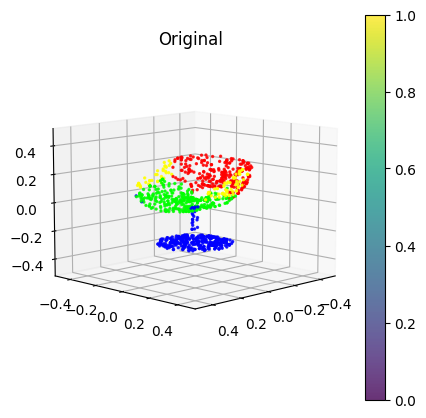

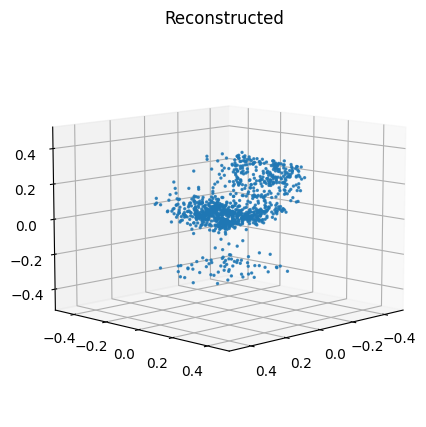

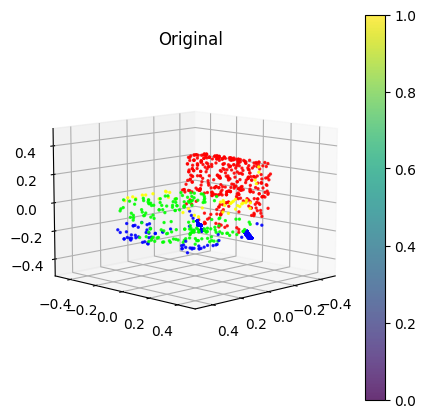

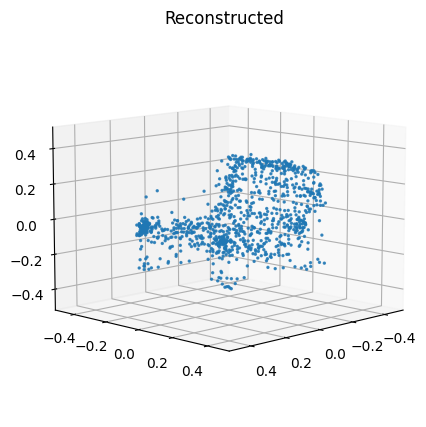

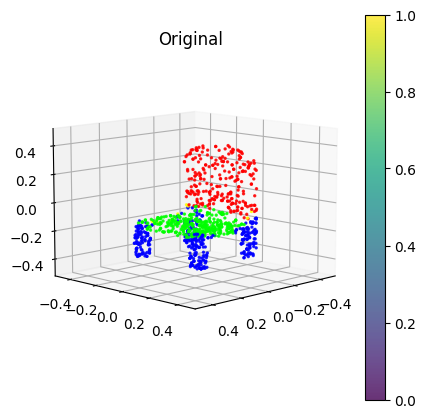

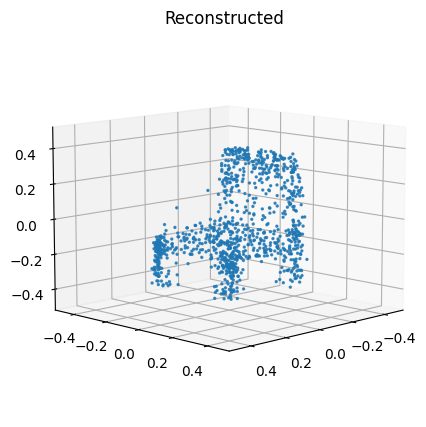

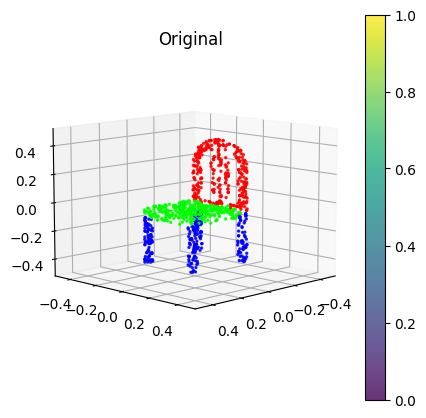

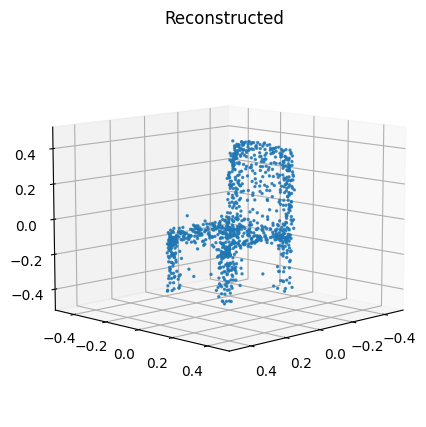

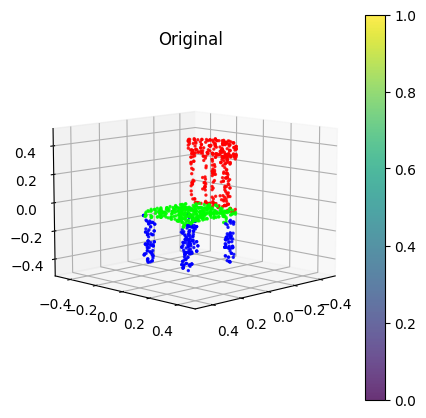

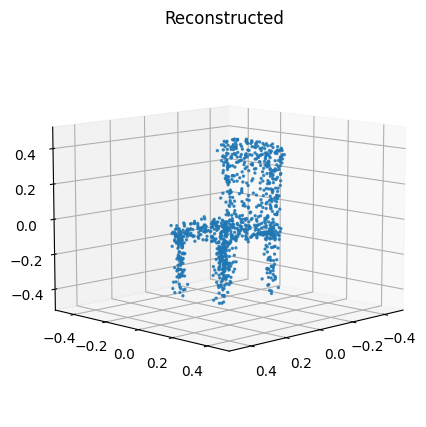

In [9]:
# Students TODO: MAKE your plots and analysis

# 5 examples to visualize per questions (e, f)
examples_to_visualize = ['8a67fd47001e52414c350d7ea5fe2a3a',
                         '1e0580f443a9e6d2593ebeeedbff73b',
                         'd3562f992aa405b214b1fd95dbca05',
                         '4e8d8792a3a6390b36b0f2a1430e993a',
                         '58479a7b7c157865e68f66efebc71317']

# You can (also) use the function for the reconstructions or the part-predictions 
# (for the latter check the kwargs parameter 'c' of matplotlib.
    # plot_3d_point_cloud, eg. try plot_3d_point_cloud(loaders['test'].dataset.pointclouds[0])
    
model.eval()   # Do not forget this.! We are not training any more (OK, since we do not 
               # have batch-norm, drop-out etc. this is not so important, however it is good standard 
               # practice)
# reconstruct all test set
point_clouds, reconstructed_pcd, part_mask, shape_names = model.reconstruct_with_part(loaders['test'])
color_code = np.array([[1.0,0.0,0.0],[0.0,1.0, 0.0],[0.0, 0.0, 1.0],[1.0, 1.0, 0.0]])

# Compute accuracy of part mask prediction

accuracy = (part_mask.cpu().numpy() == loaders['test'].dataset.part_masks).sum() / (part_mask.shape[0] * part_mask.shape[1])
print("Part classification accuracy:", accuracy)

for example in examples_to_visualize:
    idx = shape_names.index(example)
    reconstructed_point_cloud = reconstructed_pcd[idx].cpu().numpy()
    point_cloud = point_clouds[idx].cpu().numpy()
    color = color_code[part_mask[idx].cpu().numpy()]
    plot_3d_point_cloud(point_cloud, in_u_sphere=True, title='Original',c = color)
    plot_3d_point_cloud(reconstructed_point_cloud, in_u_sphere=True, title='Reconstructed')
    plt.show()

Max Chamfer Distance: tensor(0.0051, device='cuda:0')
Min Chamfer Distance: tensor(0.0007, device='cuda:0')


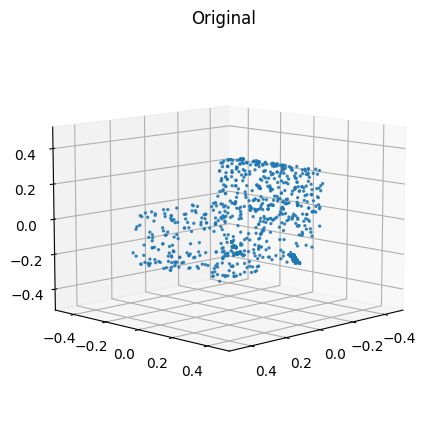

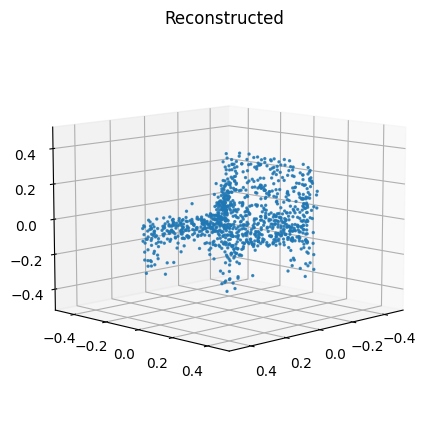

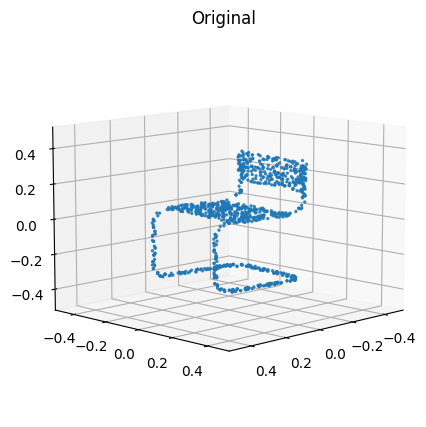

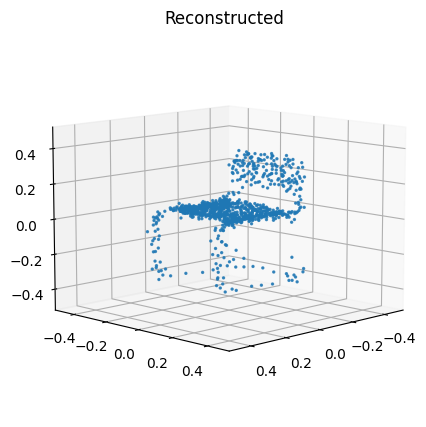

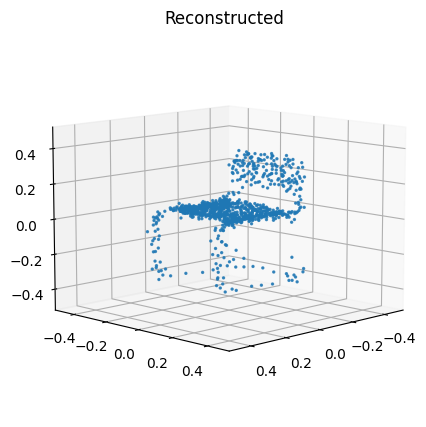

In [11]:
from cs233_gtda_hw4.losses.chamfer import chamfer_loss
chamfer_dist = chamfer_loss(point_clouds, reconstructed_pcd)
max_chamfer_dist, max_idx = chamfer_dist.max(), chamfer_dist.argmax()
min_chamfer_dist, min_idx = chamfer_dist.min(), chamfer_dist.argmin()
print('Max Chamfer Distance:', max_chamfer_dist)
print('Min Chamfer Distance:', min_chamfer_dist)

max_recon_pcd = reconstructed_pcd[max_idx].cpu().numpy()
max_orig_pcd = point_clouds[max_idx].cpu().numpy()
plot_3d_point_cloud(max_orig_pcd, in_u_sphere=True, title='Original')
plot_3d_point_cloud(max_recon_pcd, in_u_sphere=True, title='Reconstructed')
min_recon_pcd = reconstructed_pcd[min_idx].cpu().numpy()
min_orig_pcd = point_clouds[min_idx].cpu().numpy()
plot_3d_point_cloud(min_orig_pcd, in_u_sphere=True, title='Original')
plot_3d_point_cloud(min_recon_pcd, in_u_sphere=True, title='Reconstructed')

## Why reconstruct error is different
- In the worst case, the dimension of the chair is underestimated, most points concentrated to a smaller profile, while only a few points scatter outside. When computing CD, all points in the original point cloud that are outside of the dense reconstructed region have to match to a point further away. Hence increase the average chamfer distance. In the best case, the shape dimension looks correct.

## T-sNE embedding
- Chairs with similar shapes and visual appearances are close together. chairs that are significantly different are located further apart

In [12]:
# Last, save the latent codes of the test data and go to the 
# measuring_part_awareness and tsne_plot_with_latent_codes code.

latent_codes = []

# Students TODO: Extract the latent codes and save them, so you can analyze them later.
latent_codes = model.embed(point_clouds).cpu().numpy()

np.savez(osp.join(top_out_dir, model_tag +'_latent_codes_part_aware'), 
         latent_codes=latent_codes, 
         test_names=shape_names)